# Convolutional Layers

### Implementing convolutional layers with keras

In [1]:

import sys

assert sys.version_info >= (3, 7)

In [2]:
import tensorflow as tf
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt

In [3]:
if tf.config.list_physical_devices('GPU'):
  print("Connected to GPU successfully!")
else:
  print("No GPU connnected")

Connected to GPU successfully!


In [4]:
images=load_sample_images()["images"]
images=tf.keras.layers.CenterCrop(height=75,width=115)(images)
images=tf.keras.layers.Rescaling(scale=1/255)(images)

In [5]:
images.shape

TensorShape([2, 75, 115, 3])

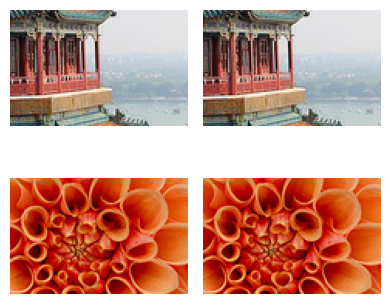

In [6]:
plt.figure(figsize=(4,4))
for img_idx in (0,1):
    for j in (0,1):
        plt.subplot(2,2,img_idx*2+j+1)
        plt.imshow(images[img_idx,:,:,:])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
tf.keras.utils.set_random_seed(42)

conv_layer=tf.keras.layers.Conv2D(filters=32,kernel_size=8)
fmap=conv_layer(images)

In [8]:
fmap.shape

TensorShape([2, 68, 108, 32])

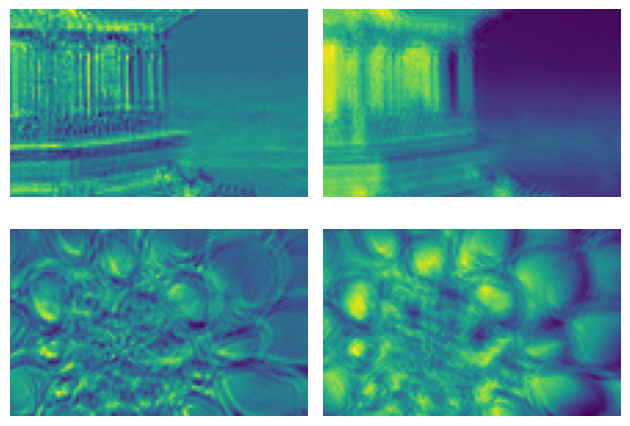

In [9]:
for img_idx in (0,1):
    for fmap_idx in (0,1):
        plt.subplot(2,2,img_idx*2+fmap_idx+1)
        plt.imshow(fmap[img_idx,:,:,fmap_idx])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
conv_layer=tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding="same")
fmap=conv_layer(images)

In [11]:
fmap.shape

TensorShape([2, 75, 115, 32])

In [12]:
conv_layer=tf.keras.layers.Conv2D(filters=32,kernel_size=7,padding="same",
                                 strides=2)
fmap=conv_layer(images)
fmap.shape

TensorShape([2, 38, 58, 32])

In [13]:
kernel,biases=conv_layer.get_weights()

In [14]:
kernel.shape

(7, 7, 3, 32)

In [15]:
biases.shape

(32,)

In [16]:
filters=tf.random.normal([7,7,3,2])
biases=tf.zeros([2])
fmaps=tf.nn.conv2d(images,filters,strides=1,padding="SAME")+biases

In [17]:
fmaps.shape

TensorShape([2, 75, 115, 2])

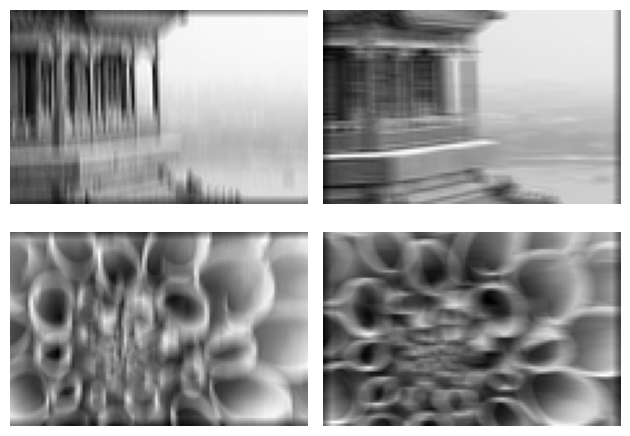

In [18]:
import numpy as np

filters=np.zeros([7,7,3,2])
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1
fmaps=tf.nn.conv2d(images,filters,strides=1,padding="SAME")+biases

for image_idx in (0,1):
  for fmap_idx in (0,1):
    plt.subplot(2,2,image_idx*2+fmap_idx+1)
    plt.imshow(fmaps[image_idx,:,:,fmap_idx],cmap="gray")
    plt.axis("off")
plt.tight_layout()


# Pooling Layers


### Max pooling


In [19]:
max_pool=tf.keras.layers.MaxPool2D(pool_size=2)

In [20]:
output=max_pool(images)

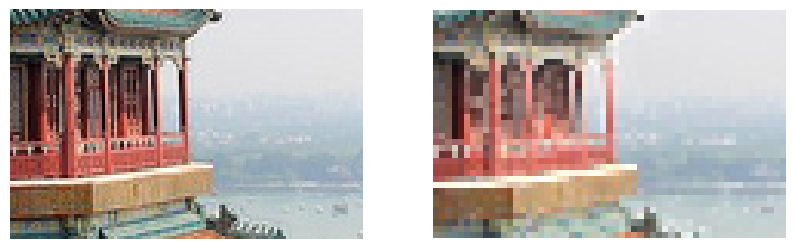

In [21]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(output[0])
plt.axis("off")
plt.show()


##### Depth-wise pooling

In [22]:
class DepthPool(tf.keras.layers.Layer):
  def __init__(self,pool_size=2,**kwargs):
    super().__init__(**kwargs)
    self.pool_size=pool_size

  def call(self,inputs):
    shape=tf.shape(inputs)
    groups=shape[-1]//self.pool_size
    new_shape=tf.concat([shape[:-1],[groups,self.pool_size]],axis=0)
    return tf.reduce_max(tf.reshape(inputs,new_shape),axis=-1)    #So for every [batch, height, width, group], it
                                                                    #looks at the 3 values in that group and picks the maximum.




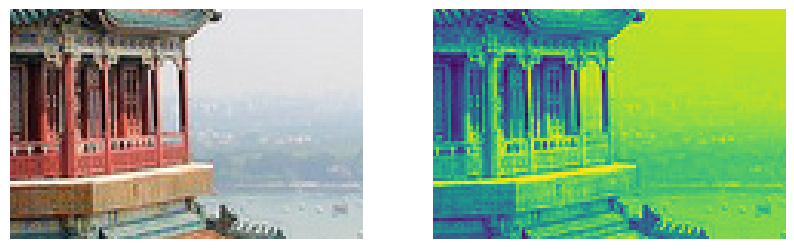

In [23]:
depth_output=DepthPool(pool_size=3)(images)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)

plt.imshow(images[0])
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(depth_output[0])
plt.axis("off")
plt.show()

##### Global Average Pooling

In [24]:
global_avg_pooling=tf.keras.layers.GlobalAveragePooling2D()

In [25]:
global_avg_pooling=tf.keras.layers.Lambda(lambda X:tf.reduce_mean(X,axis=[1,2]))

# CNN Architectures

###### Tackling Fashion MNIST With a CNN

In [26]:
mnist=tf.keras.datasets.fashion_mnist.load_data()
(X_train_full,y_train_full),(X_test,y_test)=mnist
X_train_full=np.expand_dims(X_train_full,axis=-1).astype(np.float32)/255
X_test=np.expand_dims(X_test,axis=-1).astype(np.float32)/255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
from functools import partial

DefaultConv2D=partial(tf.keras.layers.Conv2D,kernel_size=3,padding="same",activation="relu",
                      kernel_initializer="he_normal")

model=tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[28,28,1]),
    DefaultConv2D(filters=64,kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation="softmax")


])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",
              metrics=["accuracy"])
model.fit(X_train,y_train,
          epochs=10,
          validation_data=(X_valid,y_valid))
score=model.evaluate(X_test,y_test)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.5781 - loss: 1.1634 - val_accuracy: 0.8644 - val_loss: 0.3900
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8368 - loss: 0.4740 - val_accuracy: 0.8876 - val_loss: 0.3231
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8685 - loss: 0.3897 - val_accuracy: 0.8992 - val_loss: 0.2780
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8846 - loss: 0.3423 - val_accuracy: 0.9002 - val_loss: 0.2814
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8929 - loss: 0.3073 - val_accuracy: 0.9040 - val_loss: 0.2773
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9050 - loss: 0.2882 - val_accuracy: 0.9050 - val_loss: 0.2600
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9124 - loss: 0.2603 - val_accuracy: 0.9066 - val_loss: 0.2709
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9169 - loss: 

## GoogLeNet

In [30]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input, Concatenate
from tensorflow.keras.models import Model

def InceptionModule(x,f1,f3r,f3,f5r,f5,proj):

  path1=Conv2D(f1,kernel_size=1,padding="same",activation="relu")(x)

  path2=Conv2D(f3r,kernel_size=1,padding="same",activation="relu")(x)
  path2=Conv2D(f3,kernel_size=3,padding="same",activation="relu")(path2)

  path3=Conv2D(f5r,kernel_size=1,padding="same",activation="relu")(x)
  path3=Conv2D(f5,kernel_size=5,padding="same",activation="relu")(path3)

  path4=MaxPooling2D(pool_size=3,strides=1,padding="same")(x)
  path4=Conv2D(proj,kernel_size=1,padding="same",activation="relu")(path4)

  return Concatenate(axis=-1)([path1,path2,path3,path4])

In [31]:
from tensorflow.keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Activation,Input,Dropout

input_layer=Input(shape=(28,28,1))

x=Conv2D(filters=64,kernel_size=7,strides=2,padding="same",activation="relu")(input_layer)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)
x=BatchNormalization()(x)

x=Conv2D(64,kernel_size=1,padding="same",activation="relu")(x)
x=Conv2D(192,kernel_size=3,padding="same",activation="relu")(x)
x=BatchNormalization()(x)
x=Activation("relu")(x)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)

x=InceptionModule(x,64,96,128,12,32,32)
x=InceptionModule(x,128,128,192,32,96,64)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)

x=InceptionModule(x,192, 96, 208, 16, 48, 64)
x=InceptionModule(x,160, 112, 224, 24, 64, 64)
x=InceptionModule(x, 128, 128, 256, 24, 64, 64)
x=InceptionModule(x,112, 144, 288, 32, 64, 64)
x=InceptionModule(x,256, 160, 320, 32, 128, 128)
x=MaxPooling2D(pool_size=3,strides=2,padding="same")(x)

x=InceptionModule(x,256, 160, 320, 32, 128, 128)
x=InceptionModule(x,384, 192, 384, 48, 128, 128)
x=GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x=Dense(10,activation="softmax")(x)


model=Model(input_layer,x)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │      3,200 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 7, 7, 64)  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 7, 7, 64)  │        256 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 7, 7, 64)  │      4,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 7, 7, 192) │    110,784 │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 192) │        768 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 7, 7, 192) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 4, 4, 192) │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 4, 4, 96)  │     18,528 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 4, 4, 12)  │      2,316 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 4, 4, 192) │          0 │ max_pooling2d_5[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 64)  │     12,352 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 4, 4, 128) │    110,720 │ conv2d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 4, 4, 32)  │      9,632 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 4, 4, 32)  │      6,176 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 256) │          0 │ conv2d_11[0][0],  │
│ (Concatenate)       │                   │            │ conv2d_13[0][0],  │
│                     │                   │            │ conv2d_15[0][0],  │
│                     │                   │            │ conv2d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 4, 4, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 4, 4, 32)  │      8,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,974,582 (22.79 MB)

 Trainable params: 5,974,070 (22.79 MB)

 Non-trainable params: 512 (2.00 KB)

In [32]:
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy"])
model.fit(X_train,y_train,
          epochs=10,
          validation_data=(X_valid,y_valid))
score=model.evaluate(X_test,y_test)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 78s 27ms/step - accuracy: 0.7219 - loss: 0.7421 - val_accuracy: 0.8448 - val_loss: 0.4235
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.8710 - loss: 0.3602 - val_accuracy: 0.8936 - val_loss: 0.3172
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8906 - loss: 0.3018 - val_accuracy: 0.8810 - val_loss: 0.3499
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.9052 - loss: 0.2659 - val_accuracy: 0.8820 - val_loss: 0.3295
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9142 - loss: 0.2380 - val_accuracy: 0.8940 - val_loss: 0.3182
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9195 - loss: 0.2217 - val_accuracy: 0.8706 - val_loss: 0.3653
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.9266 - loss: 0.2060 - val_accuracy: 0.8702 - val_loss: 0.4243
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9313 -

## ResNet-34

In [33]:
DefaultConv2D=partial(tf.keras.layers.Conv2D,kernel_size=3,strides=1,padding="same",
                      kernel_initializer="he_normal",use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
  def __init__(self,filters,strides=1,activation="relu",**kwargs):
     super().__init__(**kwargs)
     self.activation=tf.keras.activations.get(activation)
     self.main_layers=[
         DefaultConv2D(filters,strides=strides),
         tf.keras.layers.BatchNormalization(),
         self.activation,
         DefaultConv2D(filters),
         tf.keras.layers.BatchNormalization()
     ]
     self.skip_layers=[]
     if strides>1:
      self.skip_layers=[
          DefaultConv2D(filters,kernel_size=1,strides=strides),
          tf.keras.layers.BatchNormalization()
      ]

  def call(self,inputs):
    Z=inputs
    for layer in self.main_layers:
      Z=layer(Z)
    skip_Z=inputs
    for layer in self.skip_layers:
      skip_Z=layer(skip_Z)

    return self.activation(Z+skip_Z)

In [34]:
mean=np.mean(X_train_full,axis=(0,1,2))
std=np.std(X_train_full,axis=(0,1,2))

data_preprocessing=tf.keras.Sequential([
    tf.keras.layers.Normalization(mean=mean.tolist(),variance=(std**2).tolist()),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

In [35]:
model=tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[32,32,3]),
    data_preprocessing,
    DefaultConv2D(64,kernel_size=3,strides=1,padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    # tf.keras.layers.MaxPooling2D(pool_size=3,strides=2),
])

prev_filter=64
for filters in [64]*3 +[128]*4 + [256]*6 + [512]*3:
  strides = 1 if filters==prev_filter else 2
  model.add(ResidualUnit(filters=filters,strides=strides))
  prev_filter=filters

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(100,activation="softmax"))



In [36]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 32, 32, 64)     │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 32, 32, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 32, 32, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 32, 32, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 16, 16, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 16, 16, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 16, 16, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 16, 16, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 8, 8, 256)      │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 8, 8, 256)      │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 4, 4, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 4, 4, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 4, 4, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,345,316 (81.43 MB)

 Trainable params: 21,328,292 (81.36 MB)

 Non-trainable params: 17,024 (66.50 KB)

## Using Pretrained Modes from Keras

In [41]:
model=tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [42]:
images=tf.constant(load_sample_images()["images"])
images_resized=tf.keras.layers.Resizing(height=224,width=224,crop_to_aspect_ratio=True)(images)

In [43]:
images.shape

TensorShape([2, 427, 640, 3])

In [44]:
images_resized.shape

TensorShape([2, 224, 224, 3])

In [45]:
inputs=tf.keras.applications.resnet50.preprocess_input(images_resized)
y_proba=model.predict(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [46]:
y_proba.shape

(2, 1000)

In [47]:
top_K=tf.keras.applications.resnet50.decode_predictions(y_proba,top=5)

for idx in range(len(images)):
  print(f"Image #{idx}")
  for class_id,name,y_proba in top_K[idx]:
    print(f"{class_id}-{name:12s} {y_proba:.2%}")

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image #0
n03877845-palace       54.83%
n03781244-monastery    24.40%
n02825657-bell_cote    18.74%
n02980441-castle       0.78%
n04346328-stupa        0.34%
Image #1
n04522168-vase         32.17%
n11939491-daisy        17.87%
n03530642-honeycomb    12.03%
n13040303-stinkhorn    4.49%
n07930864-cup          4.19%


# Pretrained Models for Transfer Learning

In [48]:
import tensorflow_datasets as tfds

dataset,info=tfds.load("tf_flowers",as_supervised=True,with_info=True)
dataset_size=info.splits["train"].num_examples
class_names=info.features["label"].names
num_classes=info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.5FDHJK_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [49]:


test_set_raw,valid_set_raw,train_set_raw=tfds.load(
    "tf_flowers",
    split=["train[:10%]","train[10%:25%]","train[25%:]"],
    as_supervised=True,

    )

In [50]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [51]:
dataset_size

3670

In [52]:
num_classes

5

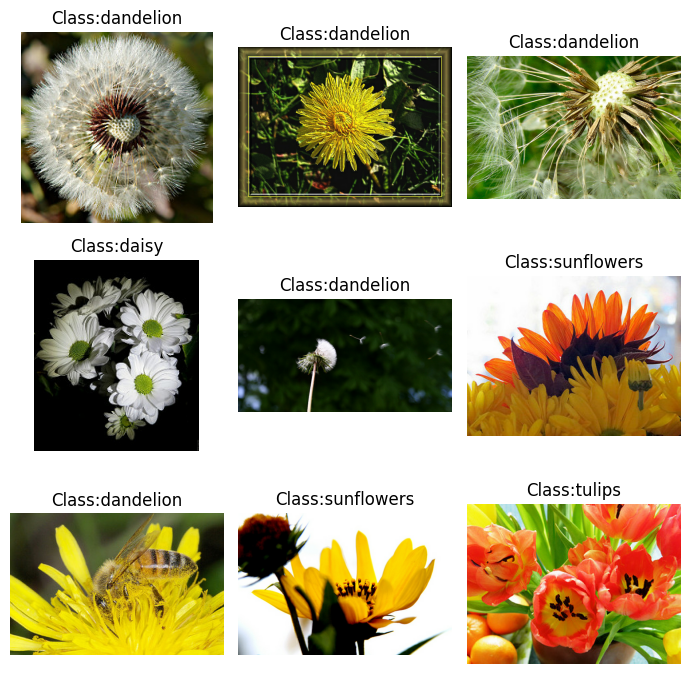

In [53]:
plt.figure(figsize=(7,7))
idx=0
for image,label in train_set_raw.take(9):
  idx+=1
  plt.subplot(3,3,idx)
  plt.imshow(image)
  plt.title(f"Class:{class_names[label]}")
  plt.axis("off")
plt.tight_layout()
plt.show()

In [54]:
tf.keras.backend.clear_session()

In [55]:
batch_size=32
preprocess=tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224,width=224,crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set=train_set_raw.map(lambda X,y: (preprocess(X),y))
train_set=train_set.shuffle(1000,seed=42).batch(batch_size).prefetch(1)
valid_set=valid_set_raw.map(lambda X,y:(preprocess(X),y)).batch(batch_size)
test_set=test_set_raw.map(lambda X,y:(preprocess(X),y)).batch(batch_size)

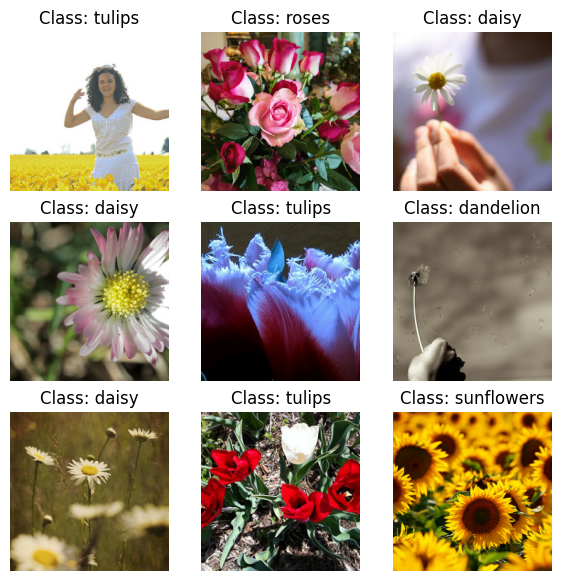

In [56]:
plt.figure(figsize=(7,7))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()


In [57]:
data_agumentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal",seed=42),
    tf.keras.layers.RandomRotation(0.05,seed=42),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])


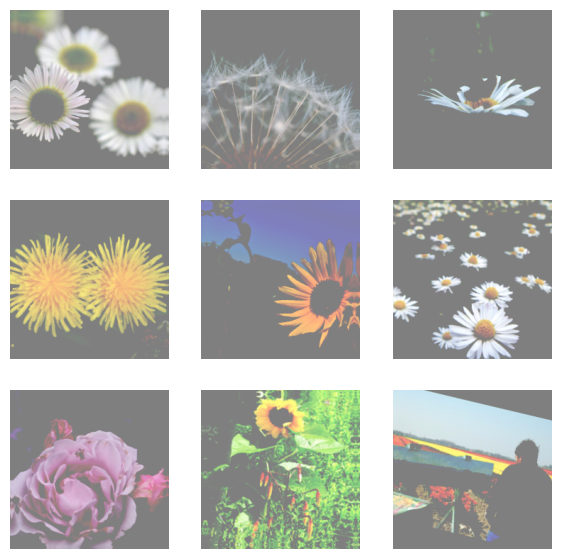

In [58]:
plt.figure(figsize=(7,7))
for X_batch,y_batch in train_set.take(1):
  X_batch_agumentation=data_agumentation(X_batch,training=True)
  for idx in range(9):
    plt.subplot(3,3,idx+1)
    plt.imshow(np.clip((X_batch_agumentation[idx]+1)/2,0,1))
    plt.axis("off")
plt.show()

In [59]:
tf.random.set_seed(42)

base_model=tf.keras.applications.xception.Xception(weights="imagenet",
                                                   include_top=False)
avg=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=tf.keras.layers.Dense(num_classes,activation="softmax")(avg)
model=tf.keras.Model(inputs=base_model.inputs,outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [60]:
for layer in base_model.layers:
  layer.trainable=False

In [61]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy"])
history=model.fit(train_set,
                  epochs=3,
                  validation_data=(valid_set))


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


86/86 ━━━━━━━━━━━━━━━━━━━━ 32s 216ms/step - accuracy: 0.7258 - loss: 4.4893 - val_accuracy: 0.8221 - val_loss: 3.2774
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.8876 - loss: 1.6215 - val_accuracy: 0.8385 - val_loss: 3.6691
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.9261 - loss: 0.8992 - val_accuracy: 0.8385 - val_loss: 4.3840


In [62]:
for indices in zip(range(33),range(33,66),range(66,99),range(99,132)):
  for idx in indices:
    print(f"{idx:3}: {base_model.layers[idx].name:22}",end="")
  print()

  0: input_layer_2          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [63]:
for layer in base_model.layers[56:]:
  layer.trainable=True

In [64]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy"])

history=model.fit(train_set,
                  epochs=10,
                  validation_data=(valid_set))


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - accuracy: 0.8320 - loss: 1.6188 - val_accuracy: 0.8675 - val_loss: 1.4208
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 274ms/step - accuracy: 0.9678 - loss: 0.1264 - val_accuracy: 0.8929 - val_loss: 0.8124
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 268ms/step - accuracy: 0.9918 - loss: 0.0438 - val_accuracy: 0.8929 - val_loss: 0.8119
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.9940 - loss: 0.0315 - val_accuracy: 0.9002 - val_loss: 0.6685
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - accuracy: 0.9943 - loss: 0.0180 - val_accuracy: 0.8911 - val_loss: 0.6730
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 284ms/step - accuracy: 0.9912 - loss: 0.0439 - val_accuracy: 0.8911 - val_loss: 0.5709
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 284ms/step - accuracy: 0.9961 - loss: 0.0134 - val_accuracy: 0.9002 - val_loss: 0.5054
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 272ms/step - accuracy: 0.9959 - loss: 0.0179 - val_accu

# Exercise

### Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.

In [65]:
import tensorflow as tf
import numpy as np

In [66]:
mnist=tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [67]:
(X_train_full,y_train_full),(X_test,y_test)=mnist
X_train_full=X_train_full/255.
X_test_full=X_test/255.

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


In [68]:
X_train.shape

(55000, 28, 28)

In [69]:
X_train=X_train[...,np.newaxis]
X_valid=X_valid[...,np.newaxis]
X_test=X_test[...,np.newaxis]

In [70]:
X_train.shape

(55000, 28, 28, 1)

In [71]:
tf.keras.utils.set_random_seed(42)

model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,kernel_size=3,padding="same",activation="relu",
                           kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64,kernel_size=3,padding="same",activation="relu",
                           kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",
              metrics=["accuracy"])
model.fit(X_train,y_train,
          epochs=10,
          validation_data=(X_valid,y_valid))
model.evaluate(X_test,y_test)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8732 - loss: 0.4077 - val_accuracy: 0.9858 - val_loss: 0.0503
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9703 - loss: 0.1031 - val_accuracy: 0.9894 - val_loss: 0.0409
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9797 - loss: 0.0694 - val_accuracy: 0.9892 - val_loss: 0.0491
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9822 - loss: 0.0570 - val_accuracy: 0.9910 - val_loss: 0.0318
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9851 - loss: 0.0472 - val_accuracy: 0.9918 - val_loss: 0.0365
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9875 - loss: 0.0405 - val_accuracy: 0.9904 - val_loss: 0.0442
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9894 - loss: 0.0317 - val_accuracy: 0.9908 - val_loss: 0.0433
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9901 - loss: 0.0303

[21.44997787475586, 0.9835000038146973]

## Satellite Image Classifier

In [1]:
import tensorflow_datasets as tfds

(ds_train,ds_valid,ds_test),info=tfds.load(
    "eurosat",
    split=["train[:70%]","train[70%:85%]","train[85%:]"],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.T7ET9I_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [2]:
dataset_size=info.splits["train"].num_examples
class_names=info.features["label"].names
num_classes=info.features["label"].num_classes

In [3]:
dataset_size

27000

In [4]:
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [5]:
num_classes

10

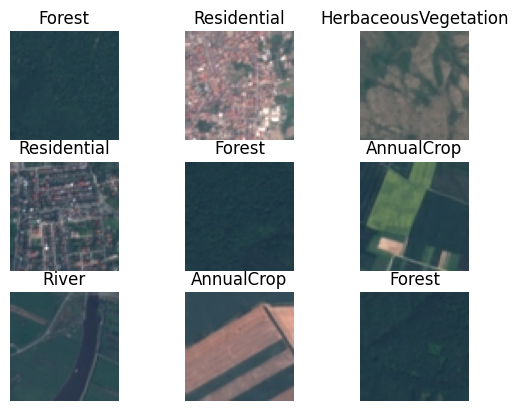

In [6]:
import matplotlib.pyplot as plt
index=0
for image,label in ds_train.take(9):
  index+=1
  plt.subplot(3,3,index)
  plt.imshow(image)
  plt.title(class_names[label])
  plt.axis("off")


In [7]:
image.shape

TensorShape([64, 64, 3])

In [8]:
import tensorflow as tf
tf.keras.backend.clear_session()

batch_size=32

preprocess=tf.keras.Sequential([
    tf.keras.layers.Resizing(height=64,width=64,crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)
])

data_agumentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.1)
])

train_set=ds_train.map(lambda X,y:(preprocess(X),y))
train_set=train_set.shuffle(1000).batch(batch_size).prefetch(1)
valid_set=ds_valid.map(lambda X,y:(preprocess(X),y)).batch(batch_size)
test_set=ds_test.map(lambda X,y:(preprocess(X),y)).batch(batch_size)



In [9]:
base_model=tf.keras.applications.MobileNetV2(
    input_shape=(64,64,3),
    weights="imagenet",
    include_top=False
)

avg_layer=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x=tf.keras.layers.Dropout(0.3)(avg_layer)
output=tf.keras.layers.Dense(num_classes,activation="softmax")(x)
model=tf.keras.Model(inputs=base_model.input,outputs=output)

/tmp/ipython-input-9-3789793642.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model=tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
for layer in base_model.layers:
  layer.trainable=False

optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy"])

model.fit(train_set,
          epochs=4,
          validation_data=(valid_set))

Epoch 1/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.7206 - loss: 1.2140 - val_accuracy: 0.8370 - val_loss: 0.8881
Epoch 2/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8004 - loss: 1.1577 - val_accuracy: 0.8319 - val_loss: 1.0338
Epoch 3/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8119 - loss: 1.2284 - val_accuracy: 0.8341 - val_loss: 1.0760
Epoch 4/4
591/591 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8273 - loss: 1.1411 - val_accuracy: 0.8074 - val_loss: 1.4523


In [11]:
len(base_model.layers)

154

In [12]:
for indices in zip(range(39), range(39, 78), range(78, 117), range(117, 154)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:33}", end="")
    print()

  0: input_layer_1                     39: block_4_depthwise                 78: block_8_project                  117: block_13_expand_BN               
  1: Conv1                             40: block_4_depthwise_BN              79: block_8_project_BN               118: block_13_expand_relu             
  2: bn_Conv1                          41: block_4_depthwise_relu            80: block_8_add                      119: block_13_pad                     
  3: Conv1_relu                        42: block_4_project                   81: block_9_expand                   120: block_13_depthwise               
  4: expanded_conv_depthwise           43: block_4_project_BN                82: block_9_expand_BN                121: block_13_depthwise_BN            
  5: expanded_conv_depthwise_BN        44: block_4_add                       83: block_9_expand_relu              122: block_13_depthwise_relu          
  6: expanded_conv_depthwise_relu      45: block_5_expand                    84: b

In [13]:
for layer in base_model.layers[72:]:
  layer.trainable=True

optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy"])

history=model.fit(train_set,
          epochs=10,
          validation_data=(valid_set))

Epoch 1/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - accuracy: 0.6243 - loss: 5.2004 - val_accuracy: 0.7686 - val_loss: 3.7428
Epoch 2/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8009 - loss: 0.9545 - val_accuracy: 0.8612 - val_loss: 1.1627
Epoch 3/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8553 - loss: 0.5466 - val_accuracy: 0.9052 - val_loss: 0.5418
Epoch 4/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8921 - loss: 0.3953 - val_accuracy: 0.9237 - val_loss: 0.3474
Epoch 5/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9018 - loss: 0.3873 - val_accuracy: 0.9299 - val_loss: 0.2835
Epoch 6/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9130 - loss: 0.3194 - val_accuracy: 0.9368 - val_loss: 0.2636
Epoch 7/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9227 - loss: 0.2971 - val_accuracy: 0.9358 - val_loss: 0.2830
Epoch 8/10
591/591 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9275 - loss: 0.2847 - val_ac

In [14]:
model.evaluate(test_set)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9427 - loss: 0.2208


[0.23095014691352844, 0.9404938220977783]